In [74]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("/home/maurizio/Documents/projects/coronavirus")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import src.tools as tools
import plotly.express as px
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
from src.data_downloader import DATA_REPOS, download_from_repo

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### download data from repos

In [75]:
dest='/home/maurizio/Documents/projects/coronavirus/data'

In [76]:
DATA_REPOS

{'world': {'url': 'https://github.com/CSSEGISandData/COVID-19',
  'streams': {'deaths': '/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv',
   'confirmed': '/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv',
   'recovered': '/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'}},
 'italy': {'url': 'https://github.com/pcm-dpc/COVID-19',
  'streams': {'andamento-nazionale': '/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv',
   'regioni': '/dati-regioni/dpc-covid19-ita-regioni.csv',
   'province': '/dati-province/dpc-covid19-ita-province.csv'}}}

In [79]:
download_from_repo(DATA_REPOS['world']['url'], filename=DATA_REPOS['world']['streams']['deaths'], 
                   dest='/home/maurizio/Documents/projects/coronavirus/data')

In [80]:
download_from_repo(DATA_REPOS['world']['url'], filename=DATA_REPOS['world']['streams']['confirmed'], 
                   dest='/home/maurizio/Documents/projects/coronavirus/data')

In [81]:
download_from_repo(DATA_REPOS['world']['url'], filename=DATA_REPOS['world']['streams']['recovered'], 
                   dest='/home/maurizio/Documents/projects/coronavirus/data')

In [82]:
download_from_repo(DATA_REPOS['italy']['url'], filename=DATA_REPOS['italy']['streams']['andamento-nazionale'], 
                   dest='/home/maurizio/Documents/projects/coronavirus/data')

In [83]:
download_from_repo(DATA_REPOS['italy']['url'], filename=DATA_REPOS['italy']['streams']['regioni'], 
                   dest='/home/maurizio/Documents/projects/coronavirus/data')

In [84]:
download_from_repo(DATA_REPOS['italy']['url'], filename=DATA_REPOS['italy']['streams']['province'], 
                   dest='/home/maurizio/Documents/projects/coronavirus/data')

### SIRD Model definition

In [85]:
# SIR model differential equations
def deriv(y, t, N, beta, gamma, theta):
    S, I, R, D = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    dDdt = theta * I
    return dSdt, dIdt, dRdt, dDdt

def SIRModel_solver(t, beta, gamma, theta):
    return SIRModel(t, beta, gamma, theta)[3] # returns just D for optimizer

def SIRModel(t, beta, gamma, theta):
    # Initial conditions vector
    y0 = S0, I0, R0, D0
    # Integrate the SIR equations over time t
    ret = odeint(deriv, y0, t, args=(N, beta, gamma, theta))
    S, I, R, D = ret.T
    return S, I, R, D

def diff_ev_solver(params):
    beta, gamma, theta = params
    return np.mean(np.abs(SIRModel_solver(x_fit, beta, gamma, theta) - y_fit))

### toy example

beta:  0.2
gamma:  0.1
theta:  0.015
r0:  2.0
mean period of time of infection:  10.0


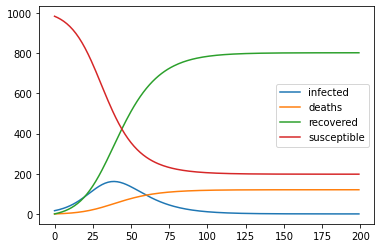

In [86]:
N = 1000 # total population Italy
I0 = 16 # Initial number of infected people (10x official estimates hypothesis)
R0 = 0 # Initial number of recovered
S0 = N - I0 - R0 # Initial susceptible population to infection.
D0 = 0 # number of deaths at initial time

params = (0.2, 0.1, 0.015)
S, I , R, D = SIRModel(range(200), *params)
print('beta: ', params[0])
print('gamma: ', params[1])
print('theta: ', params[2])
print('r0: ', params[0]/params[1])
print('mean period of time of infection: ', 1/params[1])

plt.plot(I, label='infected')
plt.plot(D, label='deaths')
plt.plot(R, label='recovered')
plt.plot(S, label='susceptible')
#plt.yscale('log')
#ax.yaxis.set_major_formatter(ScalarFormatter())

#plt.ylim(0,10000)
plt.legend()

### fit to official death data

calibrating with genetic algorithm...
beta:  2.6590038387719437
gamma:  2.408117255835338
theta:  0.001505832590082079
r0:  1.1041837071382876
mean period of time of infection:  0.4152621711325746
max number of infections  279841.0857672126
max number of deaths  6910.895755437775
mae  27.1201547727484


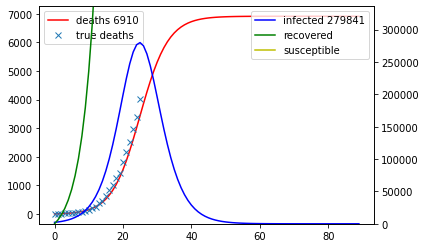

In [88]:
use_differential_evolution = True
cases_multiplier = 10
df = pd.read_csv('../data/dpc-covid19-ita-andamento-nazionale.csv').drop('stato',1)
y_fit = df['deceduti'].values
x_fit = np.linspace(0, len(y_fit), len(y_fit))
N = 60431283 # total population Italy
I0 = cases_multiplier*df['totale_attualmente_positivi'].iloc[0] # Initial number of infected people (10x official estimates hypothesis)
R0 = 0 #df['dimessi_guariti'].iloc[0] # Initial number of recovered
S0 = N - I0 - R0 # Initial susceptible population to infection.
D0 = 0 # number of deaths at initial time

bounds = [(0,5), (0, 5), (0, 5)]
if use_differential_evolution:
    print('calibrating with genetic algorithm...')
    optimization = differential_evolution(diff_ev_solver, bounds)
    params = optimization.x
else:
    params, covariances = curve_fit(f=SIRModel_solver, xdata=x_fit, ydata=y_fit, method='trf', bounds=bounds[0])
S, I , R, D = SIRModel(range(90), *params)
print('beta: ', params[0])
print('gamma: ', params[1])
print('theta: ', params[2])
print('r0: ', params[0]/params[1])
print('mean period of time of infection: ', 1/params[1])
print('max number of infections ', np.max(I))
print('max number of deaths ', np.max(D))
print('mae ', np.mean(np.abs(y_fit - SIRModel_solver(x_fit, *params))))
fig, ax1 = plt.subplots()
ax1.plot(D,'r', label='deaths '+str(int(np.max(D))))
ax1.plot(y_fit,'x', label='true deaths')
ax1.legend(loc='upper left')
ax2 = ax1.twinx()
plt.ylim(0,1.2*np.max(I))
ax2.plot(I,'b', label='infected '+str(int(np.max(I))))
ax2.plot(R,'g', label='recovered')
ax2.plot(S,'y', label='susceptible')


ax2.legend()